## learning-AI101 : vehicle price regression (ML)
### 자동차 데이터를 KNN, multiple regression, SVM, lasso, ridge, decision tree, random forest, XGBoost, gradient boosting, GPR 기법을 적용하여 regression

<br>

- **임규연 (lky473736)**
- 2024.08.12. ~ 2024.08.13.에 문서 작성
- **kaggle** : https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho
- **data abstract** : This dataset contains information about used cars. This data can be used for a lot of purposes such as price prediction to exemplify the use of linear regression in Machine Learning.


----
## <span id='ml'><mark>ML</mark></span>

machine learning으로 vehicle price를 regression한다. 목차는 아래와 같다.

- **1. 데이터 EDA (탐색적 데이터 분석) 및 데이터 전처리**
- **2. 각종 모델을 적용하여 regression 및 각 모델의 score 비교**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

-------

### 1. 데이터 EDA (탐색적 데이터 분석)

regression 진행하기 전, 데이터 구조를 파악하고, 전처리를 진행한다.

- **데이터 구조 파악 및 EDA**
    - 각 feature가 의미하는 바를 분석, 결측치 파악 후 어떻게 classification을 진행하는 것이 탁월할 지 파악
    - 각 feature에 대한 사분위수, mean, max, min, median, corr
    - seaborn을 통한 corr 상관관계 및 histplot 시각화
    - 각 feature에 대한 box plot 시각화
    - target의 도수를 bar plot 시각화
    
- **전처리**
    - train, test, val set으로 split
    - scaling (Z-score normalization)
    - 결측치 확인 및 filling by everage value
    - Polynormial Feature
    
아래와 같은 순서로 진행한다.

- **순서**
    - (1) dataframe으로 파일 열기 및 head, info 파악
    - (2) 각 describe를 통한 편향성 확인 및 기초통계량 확인
    - (3) 각 열마다 unique한 component 목록 확인 및 전처리 여부 판단 후 수행
    - (4) seaborn heatmap로 상관관계 파악
    - (5) seaborn pairplot으로 상관관계 시각화
    - (6) outlier 확인 위해 boxplot 시각화
    - (7) 결측치 확인 및 filling by evarage value
    - (8) 범주형 feature에 대한 전처리 및 labeling and encoding
    - (9) input, target set -> train, test, val set으로 split + feature selection set도 구성
    - (10) scaling (Z-score normalization)

#### (1) dataframe으로 파일 열기 및 head, info 파악

이번 regression은 조금 난해한 길을 가려고 한다. 현재 ./data/vehicle 디렉토리 안에는 아래와 같이 파일이 구성되어 있다.

```sh
alphastation:learning-ai101 alphastation$ ls -lha ./report/data/vehicle
total 3472
drwxr-xr-x   6 alphastation  staff   192B  8 13 00:03 .
drwxr-xr-x  12 alphastation  staff   384B  8 13 00:02 ..
-rw-rw-r--@  1 alphastation  staff   346K  1 14  2023 CAR DETAILS FROM CAR DEKHO.csv
-rw-rw-r--@  1 alphastation  staff   1.0M  1 14  2023 Car details v3.csv
-rw-rw-r--@  1 alphastation  staff    17K  1 14  2023 car data.csv
-rw-rw-r--@  1 alphastation  staff   345K  1 14  2023 car details v4.csv
```
각 파일은 아래와 같다.
- car data.csv : 기본적인 feature만 구성
- Car details v3.csv : 기본적인 feature + 세부적인 범주형 feature
- Car details v4.csv : v3보다 정교해진 data, component 더 많아짐
- CAR DETAILS FROM CAR DEKHO.csv

이 중 가장 feature 수가 많은 Car details v4.csv dataset을 이용하여 regression을 진행해보겠다.

In [2]:
# 파일 열기 및 head, info 파악

df = pd.read_csv('data/vehicle/car details v4.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                2059 non-null   object 
 1   Model               2059 non-null   object 
 2   Price               2059 non-null   int64  
 3   Year                2059 non-null   int64  
 4   Kilometer           2059 non-null   int64  
 5   Fuel Type           2059 non-null   object 
 6   Transmission        2059 non-null   object 
 7   Location            2059 non-null   object 
 8   Color               2059 non-null   object 
 9   Owner               2059 non-null   object 
 10  Seller Type         2059 non-null   object 
 11  Engine              1979 non-null   object 
 12  Max Power           1979 non-null   object 
 13  Max Torque          1979 non-null   object 
 14  Drivetrain          1923 non-null   object 
 15  Length              1995 non-null   float64
 16  Width 

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0


각 feature가 의미하는 바는 아래와 같다.

- **0   Make**                : 차량 제조사 (예: Toyota, Ford, BMW)
- **1   Model**               : 차량 모델명 (예: Corolla, Mustang, X5)
- **2   Price**               : 차량 가격 (정수형, 통화 단위로 나타냄)
- **3   Year**                : 차량 제조 연도
- **4   Kilometer**           : 차량 주행 거리 (킬로미터 단위)
- **5   Fuel Type**           : 연료 종류 (예: Gasoline, Diesel, Electric)
- **6   Transmission**        : 변속기 종류 (예: Manual, Automatic)
- **7   Location**            : 차량이 위치한 장소 (판매 지역)
- **8   Color**               : 차량 색상
- **9   Owner**               : 차량 소유자 정보 (예: 첫 번째 소유자, 두 번째 소유자)
- **10  Seller Type**         : 판매자 유형 (예: 개인, 딜러)
- **11  Engine**              : 엔진 사양 (배기량 및 기타 엔진 정보)
- **12  Max Power**           : 최대 출력 (보통 마력 단위로 표시)
- **13  Max Torque**          : 최대 토크 (보통 뉴턴미터(Nm) 단위로 표시)
- **14  Drivetrain**          : 구동 방식 (예: FWD(전륜구동), RWD(후륜구동), AWD(전륜구동))
- **15  Length**              : 차량 길이 (단위: 미터)
- **16  Width**               : 차량 너비 (단위: 미터)
- **17  Height**              : 차량 높이 (단위: 미터)
- **18  Seating Capacity**    : 좌석 수
- **19  Fuel Tank Capacity**  : 연료 탱크 용량 (단위: 리터)

#### (2) 각 describe를 통한 편향성 확인 및 기초통계량 확인

In [3]:
# 기초통계량 확인

df.describe()

,Price,Year,Kilometer,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
count,2.059000e+03,2059.000000,2.059000e+03,1995.000000,1995.000000,1995.000000,1995.000000,1946.000000
mean,1.702992e+06,2016.425449,5.422471e+04,4280.860652,1767.991980,1591.735338,5.306266,52.002210
std,2.419881e+06,3.363564,5.736172e+04,442.458507,135.265825,136.073956,0.822170,15.110198
min,4.900000e+04,1988.000000,0.000000e+00,3099.000000,1475.000000,1165.000000,2.000000,15.000000
25%,4.849990e+05,2014.000000,2.900000e+04,3985.000000,1695.000000,1485.000000,5.000000,41.250000
50%,8.250000e+05,2017.000000,5.000000e+04,4370.000000,1770.000000,1545.000000,5.000000,50.000000
75%,1.925000e+06,2019.000000,7.200000e+04,4629.000000,1831.500000,1675.000000,5.000000,60.000000
max,3.500000e+07,2022.000000,2.000000e+06,5569.000000,2220.000000,1995.000000,8.000000,105.000000


위 기초통계량을 보면 아래와 같은 내용을 알 수 있다.

- 가장 오래된 차 연도는 1988, 최신의 차 연도는 2022년이니, 비교적 최신의 dataset임을 알 수 있다.
- 범주형 column은 출력되지 않고, 연속형 column의 기초통계량만 표현하고 있다.
- **가격 측면**
  - 가격의 표준편차는 약 2,419,881달러로, 가격 변동성이 크다.
  - 가격의 최소값은 49,000달러, 최대값은 35,000,000달러이다.
- **주행 거리 측면**
  - 주행 거리의 표준편차는 약 57,361킬로미터로, 주행 거리의 차이가 크다.
  - 최소 주행 거리는 0킬로미터, 최대 주행 거리는 2,000,000킬로미터이다. 아예 타지 않은 차도 있다는 뜻이다.
- **연료 탱크 용량 측면**
  - 최소 연료 탱크 용량은 15리터, 최대 용량은 105리터이다.



#### (3) 각 열마다 unique한 component 목록 확인 및 전처리 여부 판단 후 수행

In [4]:
# 각 열마다의 component를 출력

'''
#   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                2059 non-null   object 
 1   Model               2059 non-null   object 
 2   Price               2059 non-null   int64  
 3   Year                2059 non-null   int64  
 4   Kilometer           2059 non-null   int64  
 5   Fuel Type           2059 non-null   object 
 6   Transmission        2059 non-null   object 
 7   Location            2059 non-null   object 
 8   Color               2059 non-null   object 
 9   Owner               2059 non-null   object 
 10  Seller Type         2059 non-null   object 
 11  Engine              1979 non-null   object 
 12  Max Power           1979 non-null   object 
 13  Max Torque          1979 non-null   object 
 14  Drivetrain          1923 non-null   object 
 15  Length              1995 non-null   float64
 16  Width               1995 non-null   float64
 17  Height              1995 non-null   float64
 18  Seating Capacity    1995 non-null   float64
 19  Fuel Tank Capacity  1946 non-null   float64
'''

for col_name in [feature for feature in df.columns if df[feature].dtype == 'object'] :
    print (f'col_name : {col_name} \ncompo : {df[col_name].unique()}')
    print ()

col_name : Make 
compo : ['Honda' 'Maruti Suzuki' 'Hyundai' 'Toyota' 'Mercedes-Benz' 'BMW' 'Skoda'
 'Nissan' 'Renault' 'Tata' 'Volkswagen' 'Ford' 'Audi' 'Mahindra' 'MG'
 'Jeep' 'Porsche' 'Kia' 'Land Rover' 'Volvo' 'Maserati' 'Jaguar' 'Isuzu'
 'Fiat' 'MINI' 'Ferrari' 'Mitsubishi' 'Datsun' 'Lamborghini' 'Chevrolet'
 'Ssangyong' 'Rolls-Royce' 'Lexus']

col_name : Model 
compo : ['Amaze 1.2 VX i-VTEC' 'Swift DZire VDI' 'i10 Magna 1.2 Kappa2' ...
 'Ritz Vxi (ABS) BS-IV' 'XUV500 W8 [2015-2017]'
 'Figo Duratec Petrol ZXI 1.2']

col_name : Fuel Type 
compo : ['Petrol' 'Diesel' 'CNG' 'LPG' 'Electric' 'CNG + CNG' 'Hybrid'
 'Petrol + CNG' 'Petrol + LPG']

col_name : Transmission 
compo : ['Manual' 'Automatic']

col_name : Location 
compo : ['Pune' 'Ludhiana' 'Lucknow' 'Mangalore' 'Mumbai' 'Coimbatore' 'Bangalore'
 'Delhi' 'Raipur' 'Kanpur' 'Patna' 'Vadodara' 'Hyderabad' 'Yamunanagar'
 'Gurgaon' 'Jaipur' 'Deoghar' 'Agra' 'Goa' 'Warangal' 'Jalandhar' 'Noida'
 'Ahmedabad' 'Mohali' 'Navi Mumbai' 'Gha

범주형 자료들을 출력해보았다. 이런 범주형 변수들까지 학습시키기 위해선, 추후 **LabelEncoder를 이용하여 각 고유한 값들을 전부 0과 1의 고유벡터로 전환시켜야 할 것**이다.

#### (4) seaborn heatmap로 상관관계 파악
- 본 dataframe엔 범주형 column도 포함되어 있기 때문에, 연속형 자료들만 heatmap으로 표현한다.

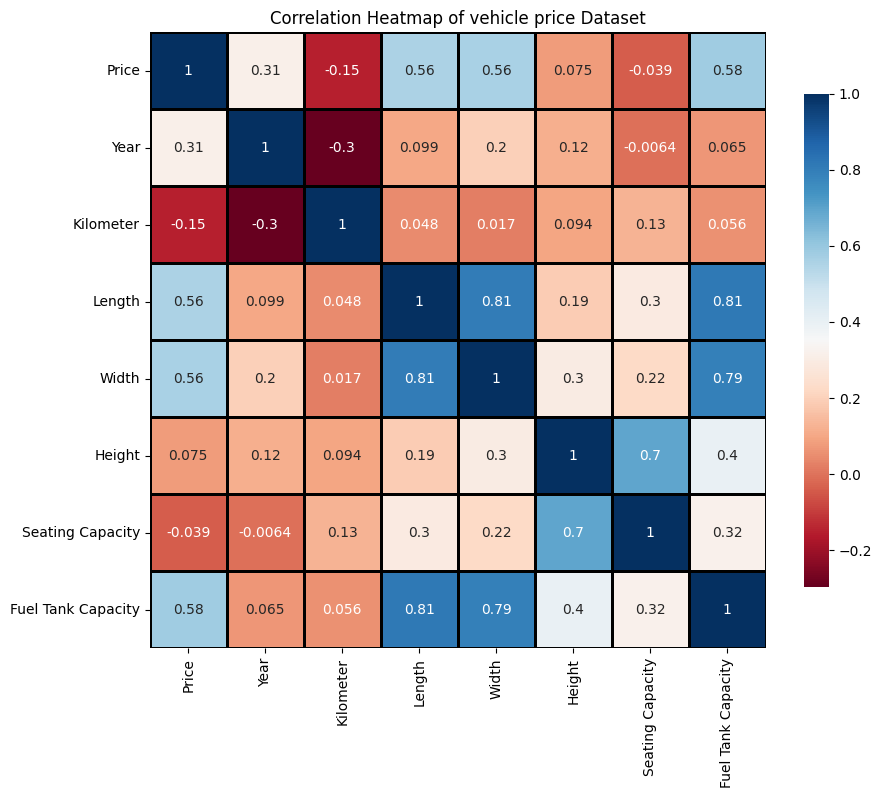

In [5]:
# seaborn heatmap

correlation_matrix = df[[feature for feature in df.columns if df[feature].dtype != 'object']].corr() 
# object, 즉 연속형 자료가 아닌 범주형 자료는 걸러내는 list comprehension 사용하여 corr 구하기
plt.figure(figsize=(10, 8)) 

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of vehicle price Dataset', fontsize=12)
plt.show()

위 heatmap을 통해 아래와 같은 사실을 유추 가능하다.
- Length와 Width가 Fuel Tank Capacity와 굉장한 양의 상관관계를 가지고 있다. 여기서 Length와 Width는 길이와 너비, Fuel Tank Capacity는 연료통의 최대 용량을 의미하는데, 이는 차량이 클 수록 연료통의 크기도 대체적으로 비례하여 커진다는 것을 의미한다.
- 또한, 대체적으로 심각한 음의 관계를 띄지는 않으며, 고른 correlation 분포를 띄고 있다.
- **target과의 상관관계**
    - target인 Price와 큰 상관관계를 보이는 것은 Length, Width, Fuel Tank capacity이다. 
    - 아마도 위의 feature가 본 regression에서 큰 importance를 가질 것임이 예상된다.
    - 가장 큰 음의 상관관계를 가진 Kilometer를 보았을 때, Kilometer (차량 주행 거리) 가 크면 Price는 낮을 가능성이 있음이 확인된다.
    - 만약에 feature selection을 진행한다면, correlation이 상대적으로 높은 Length, Width, Fuel Tank capacity를 통하여 train set, test set, val set을 구성하는 것이 바람직하다. **따라서 Length, Width, Fuel Tank capacity를 feature selection한 set을 만들어서 추후 fit해본다.**
    
    

#### (5) seaborn pairplot으로 상관관계 시각화
- 본 dataframe엔 범주형 column도 포함되어 있기 때문에, 연속형 자료들만 pairplot으로 표현한다.

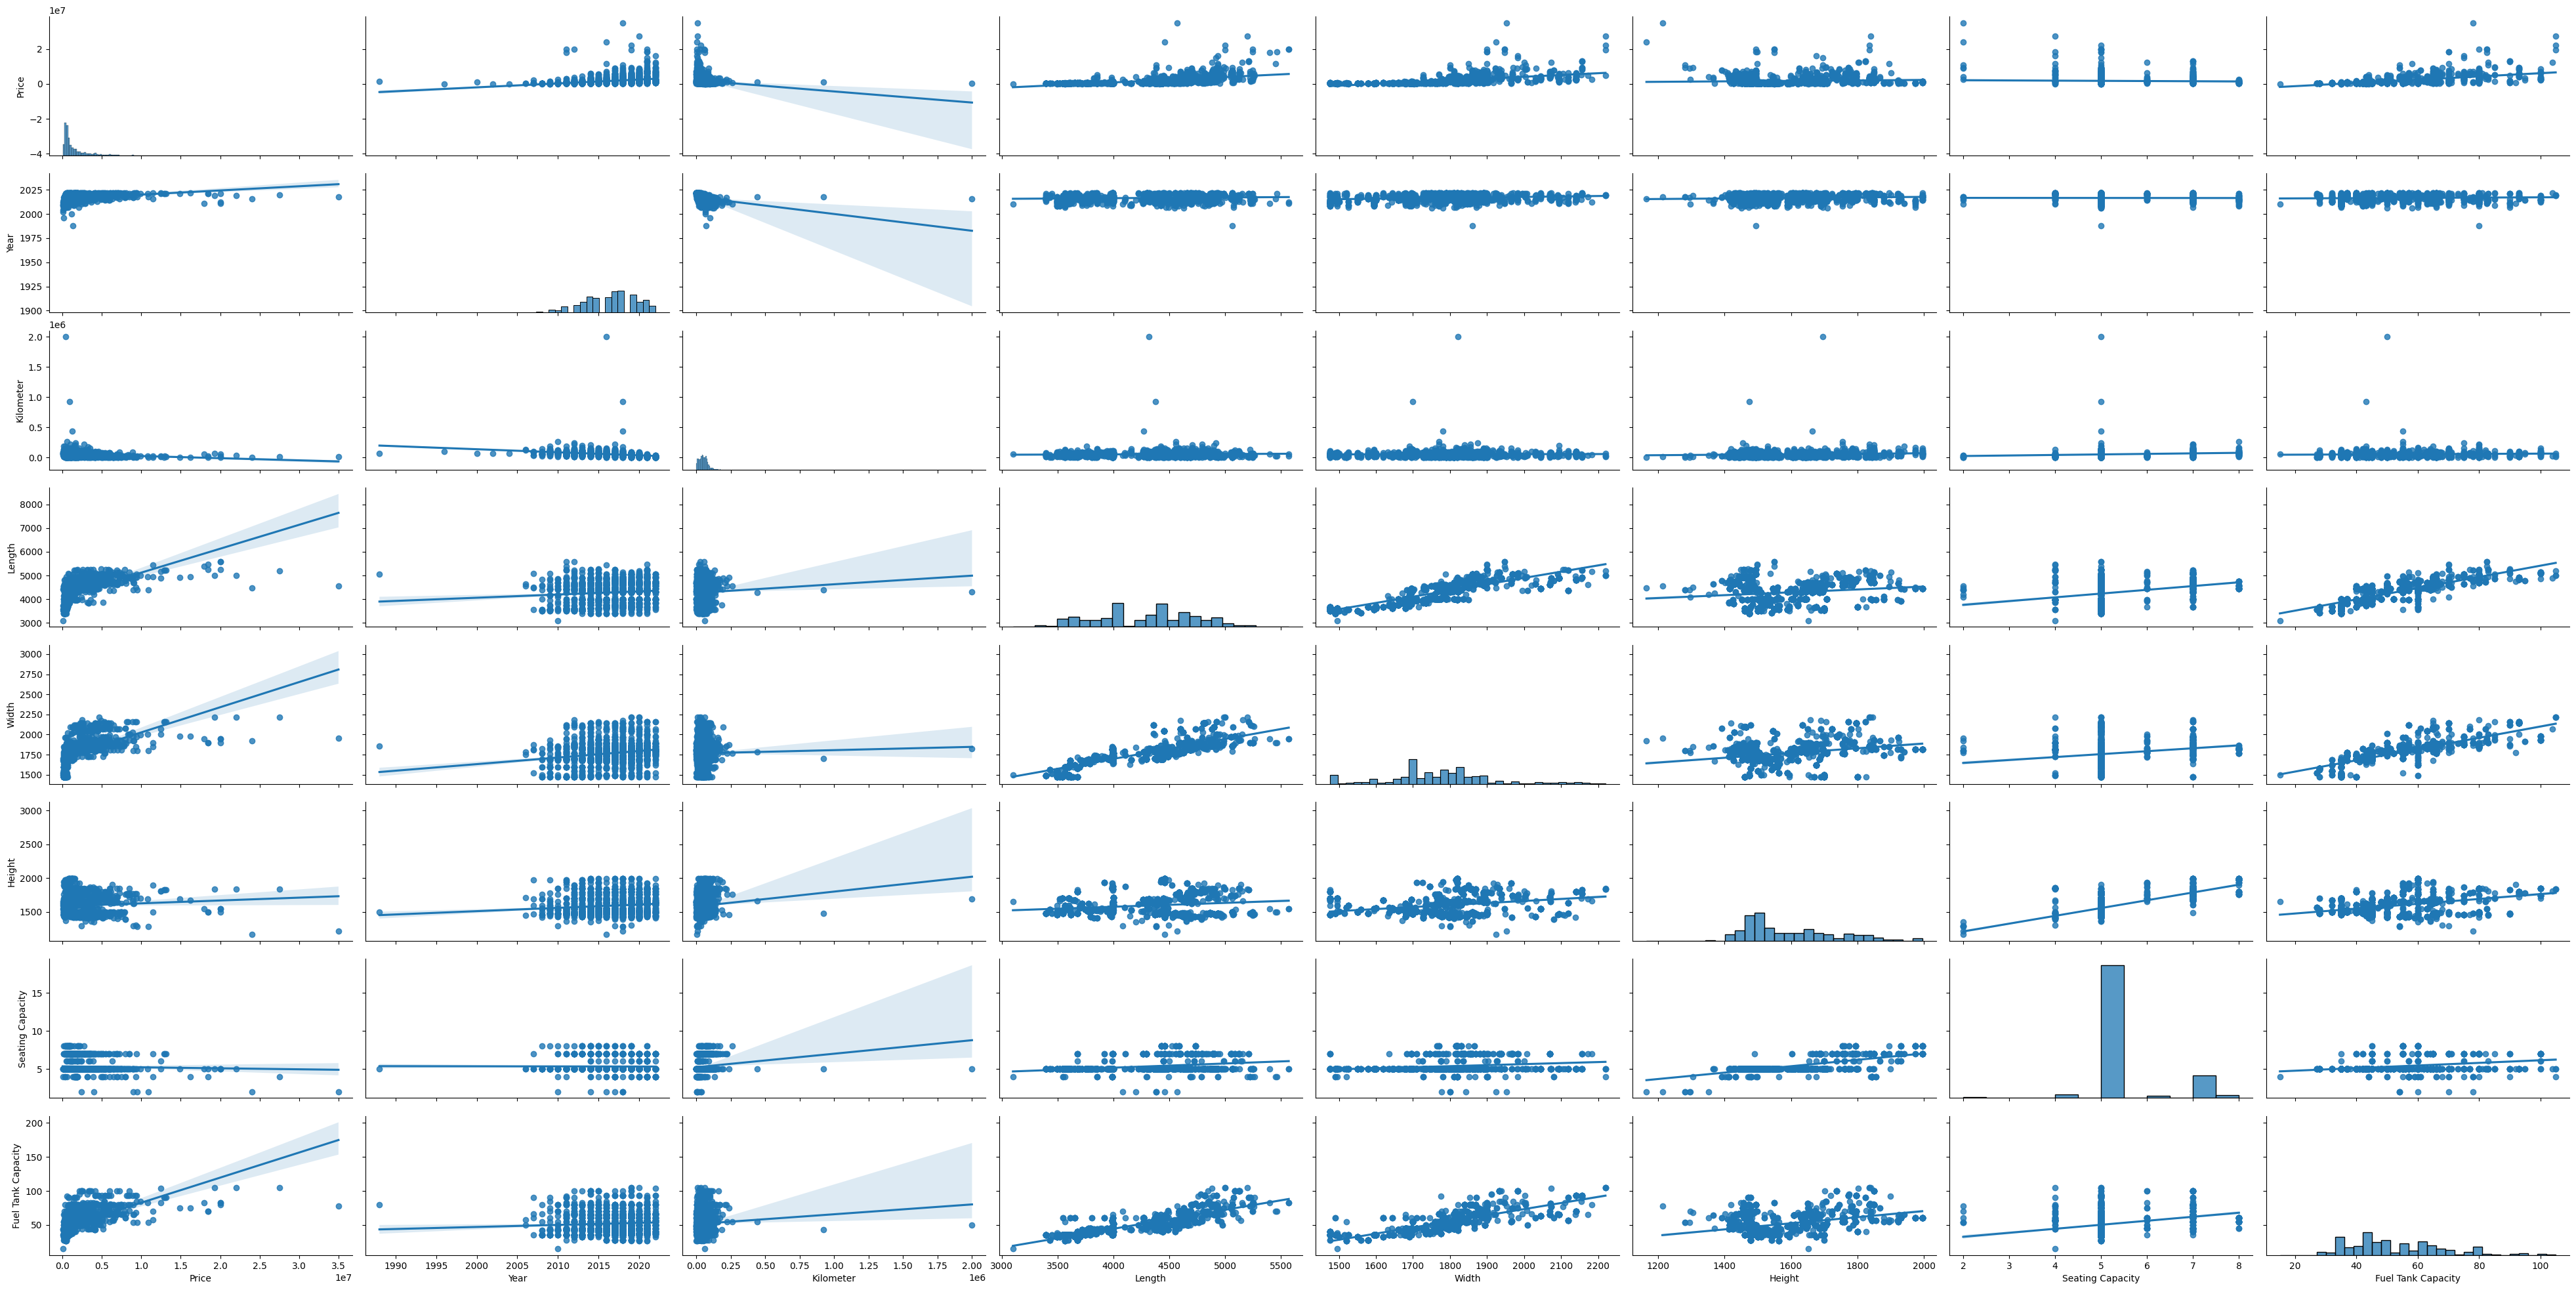

In [6]:
# pairplot visualization

sns.pairplot (df[[feature for feature in df.columns if df[feature].dtype != 'object']],
             aspect=2, kind='reg')

#### (6) outlier 확인 위해 boxplot 시각화

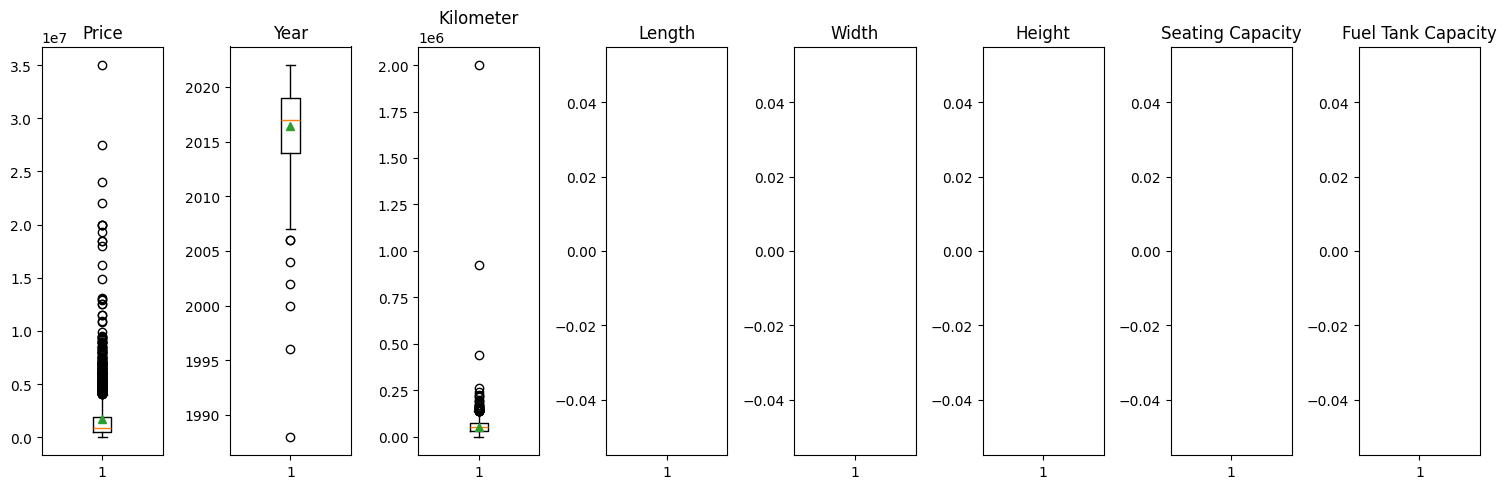

In [7]:
# box plot 그려 데이터 분포 확인

attr_list = [feature for feature in df.columns if df[feature].dtype != 'object']

# subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=len(attr_list), figsize=(15, 5))

# 각 변수에 대한 boxplot 그리기
for i, var in enumerate(attr_list) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

#### (7) 결측치 확인 및 filling by evarage value
- 연속형 데이터에 대해서는 평균값으로 대체한다.
- 범주형 데이터에 대해서는 **Missing**이라고 하는 새로운 값을 부여하여 component를 채운다.

In [8]:
# 결측치 확인

df.isnull().sum()

Make                    0
Model                   0
Price                   0
Year                    0
Kilometer               0
Fuel Type               0
Transmission            0
Location                0
Color                   0
Owner                   0
Seller Type             0
Engine                 80
Max Power              80
Max Torque             80
Drivetrain            136
Length                 64
Width                  64
Height                 64
Seating Capacity       64
Fuel Tank Capacity    113
dtype: int64

In [9]:
# 결측치 대체 
# 연속형 col에는 평균값으로 채우기
# 범주형 col에는 Missing이라는 새로운 값 지정하기

categorical = df.select_dtypes(include=['object']).columns # 범주형 col (object)
numerical = df.select_dtypes(include=[np.number]).columns # 연속형 col (int32, float32)

print (categorical, numerical)

df[categorical] = df[categorical].fillna('Missing') # Missing 채우기
df[numerical] = df[numerical].fillna(df[numerical].mean()) # 평균 채우기

print (df.isnull().sum())

Index(['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color',
       'Owner', 'Seller Type', 'Engine', 'Max Power', 'Max Torque',
       'Drivetrain'],
      dtype='object') Index(['Price', 'Year', 'Kilometer', 'Length', 'Width', 'Height',
       'Seating Capacity', 'Fuel Tank Capacity'],
      dtype='object')
Make                  0
Model                 0
Price                 0
Year                  0
Kilometer             0
Fuel Type             0
Transmission          0
Location              0
Color                 0
Owner                 0
Seller Type           0
Engine                0
Max Power             0
Max Torque            0
Drivetrain            0
Length                0
Width                 0
Height                0
Seating Capacity      0
Fuel Tank Capacity    0
dtype: int64


#### (8) 범주형 feature에 대한 전처리 및 labeling and encoding

범주형 feature에 대한 기본적인 전처리는 보통 두 종류로, labeling과 encoding이다. 각각은 매우 비슷하지만, 매우 다를 수도 있다.
- **labeling** : 범주형 데이터를 고유한 정수 값으로 변환한다. 예를 들어, ['빨강', '파랑', '초록']을 [0, 1, 2]로 변환한다. 메모리를 효율적으로 사용한다는 장점이 있지만, **만약 2가 1보다 중요하다고 모델이 판단하면 어쩌겠는가?** (따라서 time-series sequence 데이터에 적합하다.)
- **encoding** : 범주형 데이터를 0과 1을 이용하여 변환한다. 예를 들어, 아까와 같은 예시로 보았을 때, [[1, 0, 0], [0, 1, 0], [0, 0, 1]]처럼 변환한다. 범주형 데이터 간의 순서 관계를 없애고, 모델이 각 범주를 독립적으로 처리할 수는 있으나, 메모리 측면에서는 별로다.

각각에 맞는 전처리 방법이 있고, 현재도 column의 성질에 맞게끔 전처리할 예정이다. 현재 dataframe의 범주형 feature는 아래와 같다.

```python
['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color',
       'Owner', 'Seller Type', 'Engine', 'Max Power', 'Max Torque',
       'Drivetrain']

col_name : Make 
compo : ['Honda' 'Maruti Suzuki' 'Hyundai' 'Toyota' 'Mercedes-Benz' 'BMW' 'Skoda'
 'Nissan' 'Renault' 'Tata' 'Volkswagen' 'Ford' 'Audi' 'Mahindra' 'MG'
 'Jeep' 'Porsche' 'Kia' 'Land Rover' 'Volvo' 'Maserati' 'Jaguar' 'Isuzu'
 'Fiat' 'MINI' 'Ferrari' 'Mitsubishi' 'Datsun' 'Lamborghini' 'Chevrolet'
 'Ssangyong' 'Rolls-Royce' 'Lexus']

col_name : Model 
compo : ['Amaze 1.2 VX i-VTEC' 'Swift DZire VDI' 'i10 Magna 1.2 Kappa2' ...
 'Ritz Vxi (ABS) BS-IV' 'XUV500 W8 [2015-2017]'
 'Figo Duratec Petrol ZXI 1.2']

col_name : Fuel Type 
compo : ['Petrol' 'Diesel' 'CNG' 'LPG' 'Electric' 'CNG + CNG' 'Hybrid'
 'Petrol + CNG' 'Petrol + LPG']

col_name : Transmission 
compo : ['Manual' 'Automatic']

col_name : Location 
compo : ['Pune' 'Ludhiana' 'Lucknow' 'Mangalore' 'Mumbai' 'Coimbatore' 'Bangalore' ...
 'Ranga Reddy' 'Bulandshahar' 'Roorkee' 'Siliguri']

col_name : Color 
compo : ['Grey' 'White' 'Maroon' 'Red' 'Blue' 'Orange' 'Silver' 'Brown' 'Black'
 'Bronze' 'Gold' 'Beige' 'Green' 'Yellow' 'Purple' 'Others' 'Pink']

col_name : Owner 
compo : ['First' 'Second' 'Third' 'Fourth' 'UnRegistered Car' '4 or More']

col_name : Seller Type 
compo : ['Corporate' 'Individual' 'Commercial Registration']

col_name : Engine 
compo : ['1198 cc' '1248 cc' '1197 cc' '2393 cc' '1373 cc' '1991 cc' '1995 cc' ...
 '2400 cc' '793 cc' '995 cc']

col_name : Max Power 
compo : ['87 bhp @ 6000 rpm' '74 bhp @ 4000 rpm' '79 bhp @ 6000 rpm' ...
 '134 Nm @ 4000 rpm' '456@1400' '113 Nm @ 5000 rpm' '480 Nm @ 1600 rpm']
    
col_name : Max Torque 
compo : ['109 Nm @ 4500 rpm' '190 Nm @ 2000 rpm' '112.7619 Nm @ 4000 rpm'
 '113 Nm @ 4200 rpm' '343 Nm @ 1400 rpm' '130 Nm @ 4000 rpm'
 '300 Nm @ 1200 rpm' ... ]

col_name : Drivetrain 
compo : ['FWD' 'RWD' 'AWD' nan]
```

이 feature의 값은 문자열로 이루어져 있다. 따라서 이에 대한 전처리가 필수적이다. 하지만, **이들 중 \'숫자\'인데도 문자열로 취급되어 범주형으로 인식되는 열이 있다.** 아래에 서술한다.
- Make는 메이커를 뜻하며, 각각의 연관성이 전혀 없기 때문에 encoding으로 전처리한다.
- Model은 모델명을 뜻하며, 이도 역시 encoding한다.
- Fuel Type은 연료 타입인데, 이도 역시 encoding한다.
- Transmission 또한 encoding한다.
- Location 또한 encoding한다.
- Color 또한 encoding한다.
- Owner 또한 encoding한다.
- Seller Type 또한 encoding한다.
- **Engine, 여기가 문제이다.** Engine은 현재 cc를 표현하기 위해 문자열로 취급되고 있다. 이는 string parsing을 통하여 숫자만 extract한 후에 다시 연속형으로 변경할 예정이다. 
- **Max Power와 Max Torque, 여기도 문제이다.** 이 또한 bhp, Nm과 rpm을 표현하기 위해 문자열로 취급된다. 위와 같이 parsing하여 앞쪽 수치만 인정한다.
- Drivetrain은 encoding이다.

정리하자면 아래와 같다.
- **string parsing 후에 열을 float32로 변경**
    - Engine 열, Max Power 열, Max Torque 열
    
- **나머지 범주형 열은 전부 label encoding**

In [10]:
# Engine, Max Power, Max Torque 전처리

col_list = ['Engine', 'Max Power', 'Max Torque']

for i in range (df.shape[0]) :
    # print (df.iloc[i])
        
    for j in range (len(col_list)) :
        component = df.at[i, col_list[j]]
        
        # print (f'{i} | {col_list[j]} : {component}')
        
        if component != 'Missing' : # 결측치가 아니라면
#             if 'cc' in component :  # Engine
#                 df.at[i, col_list[j]] = float(component.split()[0])
            
#             else : # Max Power 혹은 Max Torque
#                 if 'rpm' in component : # 320 Nm @ 1750 rpm
#                     df.at[i, col_list[j]] = float(component.split()[0])
                    
#                 else : # 320@1750
#                     df.at[i, col_list[j]] = float(component.split('@')[0])

            # parsing algorithm 사용
            
            current_ind = 0
            current_num = ''
            
            while True : 
                if component[current_ind] not in [' ', '@'] and current_ind < len(component) :
                    current_num += component[current_ind]
                    
                else : 
                    break
                    
                current_ind += 1
                    
            #  print (current_num)
            
            df.at[i, col_list[j]] = float(current_num)
            
        else : # 결측치면
            df.at[i, col_list[j]] = 0.0

# float32로 dtype 변경
for feature in col_list : 
    df[feature] = df[feature].astype(float)

df.iloc[0]

Make                                Honda
Model                 Amaze 1.2 VX i-VTEC
Price                              505000
Year                                 2017
Kilometer                           87150
Fuel Type                          Petrol
Transmission                       Manual
Location                             Pune
Color                                Grey
Owner                               First
Seller Type                     Corporate
Engine                             1198.0
Max Power                            87.0
Max Torque                          109.0
Drivetrain                            FWD
Length                             3990.0
Width                              1680.0
Height                             1505.0
Seating Capacity                      5.0
Fuel Tank Capacity                   35.0
Name: 0, dtype: object

In [11]:
# 나머지 열은 label encoding

from sklearn.preprocessing import LabelEncoder

categorical = df.select_dtypes(include=['object']).columns
print (categorical)

for col in categorical :
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df.head()

Index(['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color',
       'Owner', 'Seller Type', 'Drivetrain'],
      dtype='object')


,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,7,106,505000,2017,87150,6,1,56,7,1,1,1198.0,87.0,109.0000,1,3990.0,1680.0,1505.0,5.0,35.0
1,19,802,450000,2014,75000,2,1,40,15,3,2,1248.0,74.0,190.0000,1,3995.0,1695.0,1555.0,5.0,42.0
2,8,1030,220000,2011,67000,6,1,39,8,1,2,1197.0,79.0,112.7619,1,3585.0,1595.0,1550.0,5.0,35.0
3,30,492,799000,2019,37500,6,1,41,13,1,2,1197.0,82.0,113.0000,1,3995.0,1745.0,1510.0,5.0,37.0
4,30,548,1950000,2018,69000,2,1,45,7,1,2,2393.0,148.0,343.0000,3,4735.0,1830.0,1795.0,7.0,55.0


#### (9) input, target set -> train, test, val set으로 split + feature selection set 구성

In [12]:
# input, target set으로 split

print (df.columns)

vehicle_target = df['Price']
vehicle_input = df.drop(columns=['Price'])

print (vehicle_input.shape, vehicle_target.shape)

Index(['Make', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type',
       'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine',
       'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height',
       'Seating Capacity', 'Fuel Tank Capacity'],
      dtype='object')
(2059, 19) (2059,)


In [13]:
# train, test, val set으로 split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vehicle_input,
                                                   vehicle_target, 
                                                   test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train, 
                                                  test_size=0.2)

print (X_train.shape, X_test.shape, X_val.shape)

(1317, 19) (412, 19) (330, 19)


In [14]:
# feature selection set도 구성

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(vehicle_input[['Length', 'Width', 'Fuel Tank Capacity']],
                                                   vehicle_target, 
                                                   test_size=0.2)

X_train_fs, X_val_fs, y_train_fs, y_val_fs = train_test_split(X_train_fs,
                                                  y_train_fs, 
                                                  test_size=0.2)

print (X_train_fs.shape, X_test_fs.shape, X_val_fs.shape)

(1317, 3) (412, 3) (330, 3)


#### (10) scaling (Z-score normalization)

In [15]:
# scaling

from sklearn.preprocessing import StandardScaler

z_normal = StandardScaler()
X_train_scaled = z_normal.fit_transform(X_train)
X_test_scaled = z_normal.transform(X_test)
X_val_scaled = z_normal.transform(X_val)

z_normal = StandardScaler()
X_train_fs_scaled = z_normal.fit_transform(X_train_fs)
X_test_fs_scaled = z_normal.transform(X_test_fs)
X_val_fs_scaled = z_normal.transform(X_val_fs)

-------

### 2. 각종 모델을 적용하여 regression
- model : KNN, multiple regression, SVM, lasso, ridge, decision tree, random forest, gradient boosting, XGBoost, GPR
- 아래와 같이 진행한다.
    - **목표**
        - 각 모델별로 random search하여 최적의 hyperparamter를 찾고, 그 hyperparameter로 fit 
        
    - **순서**
        - (1) 모델 리스트와 hyperparamater의 distributions 및 parameter scale을 정의
        - (2) 사용자 지정 함수를 생성하여, 모델을 순차적으로 학습할 수 있도록 함수형 프로그래밍을 진행
        - (3) normal set fit, visualization
            - visualization은 loss와 r^2 
                - loss : train set MSE, val set MSE, test set MSE
                - r^2 : train set r^2, val set r^2, test set r^2
        - (4) feature selection set fit, visualization

#### (1) 모델 리스트와 hyperparamater의 distributions 및 parameter scale을 정의
각 모델에 사용할 random search의 parameter scale는 아래와 같다.

In [16]:
# random search에 사용될 각 parameter의 scale을 dictionary로 정리
# model list 정의

# scipy import (for regular distributions)
from scipy.stats import uniform, randint

# model import
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = { # model 리스트
    "KNN" : KNeighborsRegressor(),
    "lasso" : Lasso(),
    "ridge" : Ridge(),
    "SVM" : SVR(),
    "decision tree" : DecisionTreeRegressor(),
    "random forest" : RandomForestRegressor(),
    "gradient boosting" : GradientBoostingRegressor(),
    "XGBoost" : XGBRegressor(),
    "GPR" : GaussianProcessRegressor()
}

param_scale = { # parameter scale
    "KNN" : {
        'n_neighbors' : randint(1, 50),
        'weights' : ['uniform', 'distance']
    },
    
    "lasso" : {
        'alpha' : uniform(0.0001, 10.0)
    },
    
    "ridge" : {
        'alpha' : uniform(0.0001, 10.0)
    },
    
    "SVM" : {
        'C' : uniform(0.01, 100.0),
        'kernel' : ['linear', 'rbf'],
        'gamma' : ['scale', 'auto']
    },
    
    "decision tree" : {
        'max_features': ['sqrt', 'log2', None],  
        'max_depth': np.arange(5, 50, 5),
        'min_samples_leaf': np.arange(1, 50, 10)
    },
    
    "random forest" : {
        'max_depth' : randint(1, 50),
        'min_samples_split' : randint(2, 50)
    },
    
    "gradient boosting" : {
        'n_estimators' : randint(50, 200),
        'learning_rate' : uniform(0.01, 0.2),
        'max_depth' : randint(3, 50)
    },
    
    "XGBoost" : {
        'n_estimators' : randint(50, 200),
        'learning_rate' : uniform(0.01, 0.2),
        'max_depth' : randint(3, 50)
    },
    
    "GPR" : {
        'alpha' : uniform(0.0001, 0.1)
    }
}

#### (2) 사용자 지정 함수를 생성하여, 모델을 순차적으로 학습할 수 있도록 함수형 프로그래밍을 진행

- 사용자 지정 함수의 이름은 **model_fit_procedurally**
- model_fit_procedurally의 paramter는 model_name, X_train, y_train, X_val, y_val, X_test, y_test이다. 
    - model_name은 여기서 model의 이름을 의미한다. (models 딕셔너리에서 keys에 해당)
    - models를 model_name으로 접근할 예정, model의 api를 의미한다. (models 딕셔너리에서 values에 해당)
- 각 모델에 대해 **random search -> best_model 도출 및 parameter 출력 + fit -> fit 후에 MSE 계산 및 출력 -> results에 MSE, r^2 저장** 순으로 진행
- random search의 n_iter 수는 300으로 고정
- random search의 scoring에 **neg_mean_squared_error**를 사용한다.
    - reference : https://velog.io/@ann9902/%EC%95%99%EC%83%81%EB%B8%94
    - scikit-learn의 내부 원리에 의해, 높을 수록 좋은 효용 함수를 적용하기 때문에, MSE의 반대를 계산한다.

In [17]:
# 모델 학습 및 평가
def model_fit_procedurally (model_name, X_train, y_train, X_val, y_val, X_test, y_test) : # models 딕셔너리의 구성 : key(모델이름) -> value(모델api)
    
    # CAUTION!
    # 여기서 X_train, y_train ... <-- 이 set은 지역변수이므로, 기존 train set, val set, test set에 영향을 끼치지 않음
    
    print(f"************** Activated : {model_name} **************")
    
    random_search = RandomizedSearchCV(
        models[model_name], param_scale[model_name], 
        n_iter=300, cv=10, scoring='neg_mean_squared_error', n_jobs=-1) # neg_mean_squard_error 적용 (내부 원리 때문)
    
    # random search 진행
    random_search.fit(X_train, y_train) # 입력받은 paramter
    best_model = random_search.best_estimator_
    
    # train MSE, r^2
    y_train_pred = best_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # val MSE, r^2
    y_val_pred = best_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    
    # test MSE, r^2
    y_test_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    result = {
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'val_rmse': val_rmse,
        'val_r2': val_r2,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }
    
    best_params = random_search.best_params_
    
    print(f"{model_name} | best params : {best_params}")
    
    print(f"{model_name} | train RMSE : {train_rmse}, R^2: {train_r2}")
    print(f"{model_name} | validation RMSE : {val_rmse}, R^2: {val_r2}")
    print(f"{model_name} | test RMSE : {test_rmse}, R^2: {test_r2}")
    
    return result, best_params

#### (3) normal set fit, visualization

In [18]:
# normal set fit

import time

results_normal = {}

for model_name in models.keys() :
    start_time = time.time() # 각 모델별로 소요 시간 측정
    
    rst_normal, _ = model_fit_procedurally(model_name, 
                                          X_train_scaled, y_train,
                                          X_val_scaled, y_val,
                                          X_test_scaled, y_test)
    
    end_time = time.time()
    
    print ("turnaround time: ", end_time - start_time)
    print()
    
    results_normal[model_name] = rst_normal
    
    
print (results_normal)

************** Activated : KNN **************
KNN | best params : {'n_neighbors': 6, 'weights': 'distance'}
KNN | train RMSE : 33127.44883612298, R^2: 0.9998210399420978
KNN | validation RMSE : 927424.7210212946, R^2: 0.7883319926566469
KNN | test RMSE : 1365601.3533558724, R^2: 0.7082858143590971
turnaround time:  4.005511999130249

************** Activated : lasso **************
lasso | best params : {'alpha': 9.939487438604708}
lasso | train RMSE : 1508439.908938262, R^2: 0.6289468217255951
lasso | validation RMSE : 1084131.042184749, R^2: 0.7107579406900879
lasso | test RMSE : 1511332.808261024, R^2: 0.6427025702240031
turnaround time:  1.8713319301605225

************** Activated : ridge **************
ridge | best params : {'alpha': 3.32483978771632}
ridge | train RMSE : 1508769.7274728578, R^2: 0.6287845433425686
ridge | validation RMSE : 1082801.8173886805, R^2: 0.7114667701755085
ridge | test RMSE : 1516683.4930061295, R^2: 0.6401681580602199
turnaround time:  1.31961131095886

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 135 is smaller than n_iter=300. Running 135 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


decision tree | best params : {'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}
decision tree | train RMSE : 33263.22600868997, R^2: 0.9998195699534813
decision tree | validation RMSE : 623917.7332232094, R^2: 0.9042028598568762
decision tree | test RMSE : 1102180.2371429186, R^2: 0.809973175567299
turnaround time:  1.0193099975585938

************** Activated : random forest **************
random forest | best params : {'max_depth': 23, 'min_samples_split': 3}
random forest | train RMSE : 446330.4657189964, R^2: 0.9675142280055107
random forest | validation RMSE : 513179.3383168559, R^2: 0.9351908672286579
random forest | test RMSE : 702918.8605242644, R^2: 0.9227105771222399
turnaround time:  219.7854619026184

************** Activated : gradient boosting **************
gradient boosting | best params : {'learning_rate': 0.11653234654195314, 'max_depth': 3, 'n_estimators': 156}
gradient boosting | train RMSE : 248003.23067859106, R^2: 0.9899701415384529
gradient boosting

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBoost | best params : {'learning_rate': 0.133021390127964, 'max_depth': 5, 'n_estimators': 133}
XGBoost | train RMSE : 125937.62745431229, R^2: 0.9974136270916639
XGBoost | validation RMSE : 588783.8934789454, R^2: 0.9146880777833534
XGBoost | test RMSE : 595857.764961007, R^2: 0.9444614063610677
turnaround time:  1071.9498710632324

************** Activated : GPR **************


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GPR | best params : {'alpha': 0.000643545031039805}
GPR | train RMSE : 33293.952671262035, R^2: 0.9998192364576396
GPR | validation RMSE : 1863634.2449891279, R^2: 0.14528908610679248
GPR | test RMSE : 2490662.063665133, R^2: 0.029625705325777796
turnaround time:  92.11341905593872

{'KNN': {'train_rmse': 33127.44883612298, 'train_r2': 0.9998210399420978, 'val_rmse': 927424.7210212946, 'val_r2': 0.7883319926566469, 'test_rmse': 1365601.3533558724, 'test_r2': 0.7082858143590971}, 'lasso': {'train_rmse': 1508439.908938262, 'train_r2': 0.6289468217255951, 'val_rmse': 1084131.042184749, 'val_r2': 0.7107579406900879, 'test_rmse': 1511332.808261024, 'test_r2': 0.6427025702240031}, 'ridge': {'train_rmse': 1508769.7274728578, 'train_r2': 0.6287845433425686, 'val_rmse': 1082801.8173886805, 'val_r2': 0.7114667701755085, 'test_rmse': 1516683.4930061295, 'test_r2': 0.6401681580602199}, 'SVM': {'train_rmse': 2333812.7139119436, 'train_r2': 0.11179721490268257, 'val_rmse': 1874903.1619920814, 'val_r

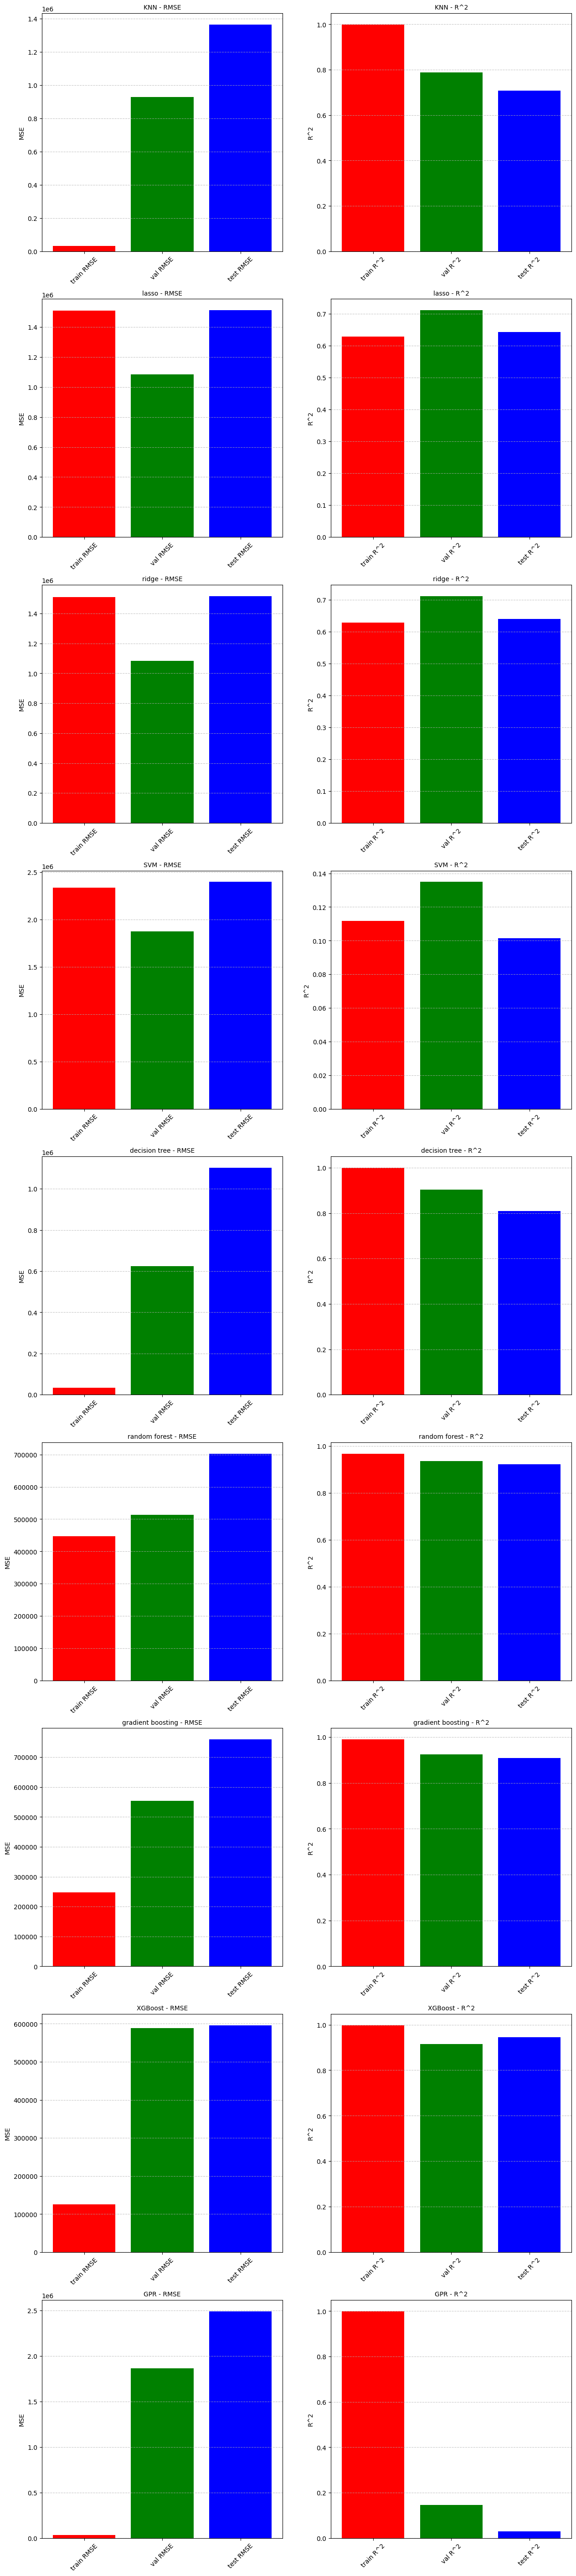

In [19]:
# visualization each MSE and R^2

model_name = list(models.keys())

fig, axes = plt.subplots(len(model_name), 2, figsize=(15, len(model_name) * 8))

for i, model in enumerate(model_name) :
    axes[i][0].bar(['train RMSE', 'val RMSE', 'test RMSE'], 
                   [results_normal[model]['train_rmse'], 
                    results_normal[model]['val_rmse'], 
                    results_normal[model]['test_rmse']],
                  color=['r', 'g', 'b'])
    
    axes[i][0].set_title(f'{model} - RMSE', fontsize=10)
    axes[i][0].set_ylabel('MSE')
    axes[i][0].tick_params(axis='x', rotation=45)
    axes[i][0].grid(True, axis='y', linestyle='--', alpha=0.7)

    axes[i][1].bar(['train R^2', 'val R^2', 'test R^2'], 
                   [results_normal[model]['train_r2'], 
                    results_normal[model]['val_r2'], 
                    results_normal[model]['test_r2']],
                   color=['r', 'g', 'b'])
    
    axes[i][1].set_title(f'{model} - R^2', fontsize=10)
    axes[i][1].set_ylabel('R^2')
    axes[i][1].tick_params(axis='x', rotation=45)
    axes[i][1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()


**매우 괴이한 결과가 나왔다.** 그 이유는, RMSE의 값이 엄청나게 높다는 것인데, 이에 대한 원인은 아래와 같이 분석 가능하다.
- 모델의 복잡성이 부족했을 수도 있다. 확실히 머신러닝의 한계이다. (스스로 designing을 할 수 없는 것)
- 극단치가 포함되어 있을 때 그럴 수 있다. 하지만, boxplot을 확인하니 이건 아닌 것 같다.
- **아니면 데이터 자체의 복잡성이 model의 복잡성보다 커서 model의 예측 능력이 하락했을 수도 있다.**

따라서 feature selection한 dataset을 이용하여 다시 학습 후, RMSE가 줄어들었는 지를 확인해보자.

#### (4) feature selection set fit, visualization

In [20]:
# feature selection set fit

import time

results_normal = {}

for model_name in models.keys() :
    start_time = time.time() # 각 모델별로 소요 시간 측정
    
    rst_normal, _ = model_fit_procedurally(model_name, 
                                          X_train_fs_scaled, y_train_fs,
                                          X_val_fs_scaled, y_val_fs,
                                          X_test_fs_scaled, y_test_fs)
    
    end_time = time.time()
    
    print ("turnaround time: ", end_time - start_time)
    print()
    
    results_normal[model_name] = rst_normal
    
print (results_normal)

************** Activated : KNN **************
KNN | best params : {'n_neighbors': 13, 'weights': 'distance'}
KNN | train RMSE : 551672.483003884, R^2: 0.9525780764725813
KNN | validation RMSE : 1421618.5749254264, R^2: 0.30041240395183055
KNN | test RMSE : 1487751.0910254105, R^2: 0.6528543070670504
turnaround time:  1.611706256866455

************** Activated : lasso **************
lasso | best params : {'alpha': 1.0443294149691}
lasso | train RMSE : 2031606.732373369, R^2: 0.3568743840378801
lasso | validation RMSE : 1378829.9746954634, R^2: 0.34189172122157296
lasso | test RMSE : 1994069.6869830731, R^2: 0.3763629771581338
turnaround time:  1.0670349597930908

************** Activated : ridge **************
ridge | best params : {'alpha': 9.981325543655482}
ridge | train RMSE : 2031611.7169587219, R^2: 0.3568712281924037
ridge | validation RMSE : 1377867.6069787673, R^2: 0.3428100667022519
ridge | test RMSE : 1994221.4783195583, R^2: 0.37626802932283554
turnaround time:  1.095020055

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SVM | best params : {'C': 99.86175709769093, 'gamma': 'scale', 'kernel': 'linear'}
SVM | train RMSE : 2566654.716834758, R^2: -0.0264821895191254
SVM | validation RMSE : 1695979.7793935603, R^2: 0.0043257812213876035
SVM | test RMSE : 2533605.4805912245, R^2: -0.006767543275500332
turnaround time:  41.006574869155884

************** Activated : decision tree **************


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 135 is smaller than n_iter=300. Running 135 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


decision tree | best params : {'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40}
decision tree | train RMSE : 549717.1765030357, R^2: 0.9529136381528076
decision tree | validation RMSE : 1814697.6399230212, R^2: -0.1399465034477101
decision tree | test RMSE : 1450436.2165773977, R^2: 0.6700497231677446
turnaround time:  1.7172698974609375

************** Activated : random forest **************
random forest | best params : {'max_depth': 47, 'min_samples_split': 2}
random forest | train RMSE : 769584.983327888, R^2: 0.9077153028973468
random forest | validation RMSE : 1327390.831450082, R^2: 0.39007905276648835
random forest | test RMSE : 1213801.63773148, R^2: 0.7689283504173785
turnaround time:  90.45974493026733

************** Activated : gradient boosting **************
gradient boosting | best params : {'learning_rate': 0.07988512870872087, 'max_depth': 6, 'n_estimators': 188}
gradient boosting | train RMSE : 554180.1798699715, R^2: 0.9521459719352606
gradient boost

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBoost | best params : {'learning_rate': 0.11229485065847664, 'max_depth': 8, 'n_estimators': 190}
XGBoost | train RMSE : 549942.0682079453, R^2: 0.9528751037983518
XGBoost | validation RMSE : 1660259.154003754, R^2: 0.04582575734496075
XGBoost | test RMSE : 1162027.208589896, R^2: 0.7882205477993209
turnaround time:  170.62816524505615

************** Activated : GPR **************


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GPR | best params : {'alpha': 0.08066262204785876}
GPR | train RMSE : 1472034.5244288482, R^2: 0.6623610716825504
GPR | validation RMSE : 1393294.7598681347, R^2: 0.3280113628902892
GPR | test RMSE : 1473642.2358996898, R^2: 0.6594072908607476
turnaround time:  98.56978487968445

{'KNN': {'train_rmse': 551672.483003884, 'train_r2': 0.9525780764725813, 'val_rmse': 1421618.5749254264, 'val_r2': 0.30041240395183055, 'test_rmse': 1487751.0910254105, 'test_r2': 0.6528543070670504}, 'lasso': {'train_rmse': 2031606.732373369, 'train_r2': 0.3568743840378801, 'val_rmse': 1378829.9746954634, 'val_r2': 0.34189172122157296, 'test_rmse': 1994069.6869830731, 'test_r2': 0.3763629771581338}, 'ridge': {'train_rmse': 2031611.7169587219, 'train_r2': 0.3568712281924037, 'val_rmse': 1377867.6069787673, 'val_r2': 0.3428100667022519, 'test_rmse': 1994221.4783195583, 'test_r2': 0.37626802932283554}, 'SVM': {'train_rmse': 2566654.716834758, 'train_r2': -0.0264821895191254, 'val_rmse': 1695979.7793935603, 'val_

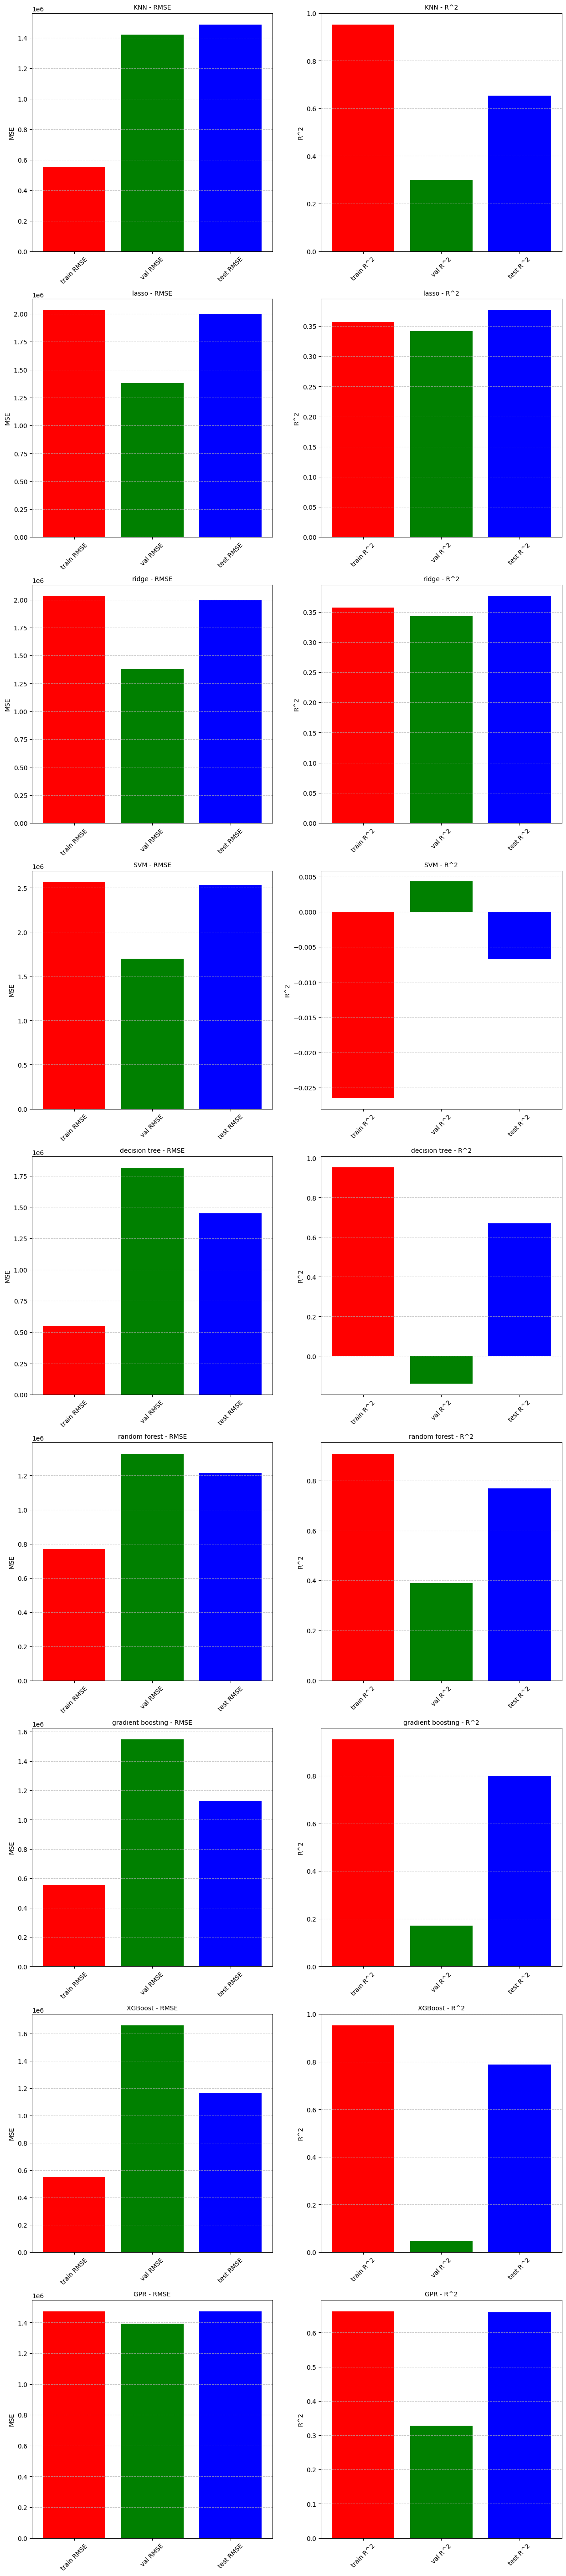

In [21]:
# visualization each MSE and R^2

model_name = list(models.keys())

fig, axes = plt.subplots(len(model_name), 2, figsize=(15, len(model_name) * 8))

for i, model in enumerate(model_name) :
    axes[i][0].bar(['train RMSE', 'val RMSE', 'test RMSE'], 
                   [results_normal[model]['train_rmse'], 
                    results_normal[model]['val_rmse'], 
                    results_normal[model]['test_rmse']],
                  color=['r', 'g', 'b'])
    
    axes[i][0].set_title(f'{model} - RMSE', fontsize=10)
    axes[i][0].set_ylabel('MSE')
    axes[i][0].tick_params(axis='x', rotation=45)
    axes[i][0].grid(True, axis='y', linestyle='--', alpha=0.7)

    axes[i][1].bar(['train R^2', 'val R^2', 'test R^2'], 
                   [results_normal[model]['train_r2'], 
                    results_normal[model]['val_r2'], 
                    results_normal[model]['test_r2']],
                   color=['r', 'g', 'b'])
    
    axes[i][1].set_title(f'{model} - R^2', fontsize=10)
    axes[i][1].set_ylabel('R^2')
    axes[i][1].tick_params(axis='x', rotation=45)
    axes[i][1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()
